# Project BattChem
## Current Status, Explaination, and Workflow
Updated 2020-05-15
------------------------------------------------------
Currently working on user interactions *(via notebook widgets and functions!?!)*, and will also work towards having more fundamental calculations availiable for EChem-based modeling *(current models are highly empirical)*

In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Nernst_Reference
import Nernst_Widgets

199.70962601361504


In [2]:
#Let's explore what comes in Nernst_Reference for now
print(Nernst_Reference.E.keys())
# In reality thought, those are not actually properly filled out. 
# Only LFP, LMO, and LCO have data in them

dict_keys(['LFP', 'LMO', 'LCO', 'LNO', 'NCA', 'NMC111', 'GRA_Br', 'GRA_Li', 'NTP', 'TPO'])


In [3]:
# I've made a starting dictionary of Reference Electrode E_0 values as well
print(Nernst_Reference.Refs.keys())
# However, I should actually include a dictionary of Half-Cell STANDARDS,
#    and then a separate Refs dictionary of common Non-Standards to use...


dict_keys(['Li', 'SCE', 'NCE', 'AgCl', 'MSE', 'SHE', 'NHE', 'AgSO'])


#### Creating Half-Cell Curves

In [4]:
PlotQ = 0 # For testing, I allow plotting to be turned off. Not well coded.
Ano,Cat = Nernst_Reference.Choose_Electrodes(Ano = "GRA_Li", Cat = "LCO", Ref = "Li")
Cathode_mAhg = Nernst_Reference.Show_Curves(Cat,1)
print("Cathode Curve Construction: Lithium Colbalt Oxide (V vs Li/Li+)")

Cathode Curve Construction: Lithium Colbalt Oxide (V vs Li/Li+)


In [5]:
Anode_mAhg = Nernst_Reference.Show_Curves(Ano,-1)
print("Anode Half-Cell Buildup, for Li-Graphite Insertion (V vs Li/Li+)")

Anode Half-Cell Buildup, for Li-Graphite Insertion (V vs Li/Li+)


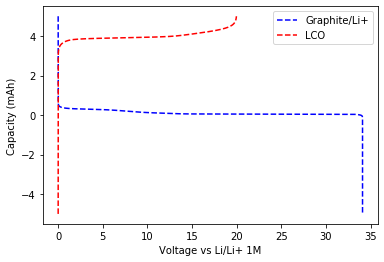

In [6]:
fig,ax = plt.subplots()
anode_m = 100/1000 #kg (times mAh/g will = Ah Loading)
cathode_m = 400/1000 #kg (times mAh/g = Ah Cathode Loading)
Ano_QV = [Anode_mAhg[0]*anode_m, Anode_mAhg[1]]
Cat_QV = [Cathode_mAhg[0]*cathode_m, Cathode_mAhg[1]] 

ax.plot(Ano_QV[0],Ano_QV[1],'b--',label='Graphite/Li+')
ax.plot(Cat_QV[0],Cat_QV[1],'r--',label='LCO')
ax.set_ylabel('Capacity (mAh)')
ax.set_xlabel('Voltage vs Li/Li+ 1M')
ax.legend()

449.27406503403756


Text(0.5, 0, 'Capacity (mAh)')

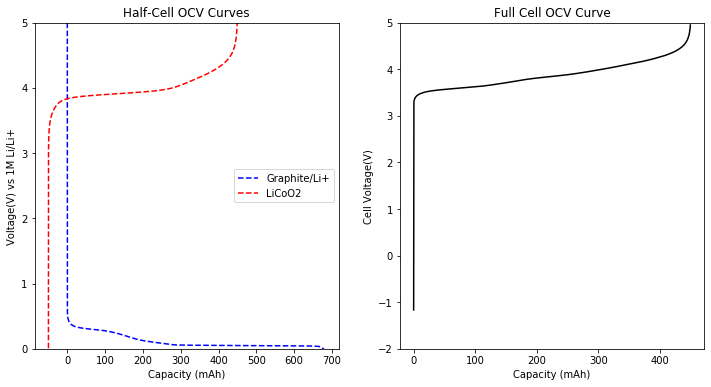

In [7]:
# Modify SOC Q-Balance and Anode, Cathode mass to create the full cell
# Note: You may enter kilograms, but then the SOC imbalance is in A*hrs

anode_m = 2 #grams
cathode_m = 10 #grams
SOC_mAh = 50 #mAh imbalance
Ano_QV, Cat_QV, Cell_QV = Nernst_Reference.combine_curves(Anode_mAhg,
                                                          anode_m,
                                                          Cathode_mAhg, 
                                                          cathode_m, 
                                                          SOC_mAh)

fig, ax = plt.subplots(1,2,figsize=[12,6])
ax[0].plot(Ano_QV[0],Ano_QV[1],'b--',label='Graphite/Li+')
ax[0].plot(Cat_QV[0],Cat_QV[1],'r--',label='LiCoO2')
ax[1].plot(Cell_QV[0],Cell_QV[1],'k-')

ax[0].set_ylim([0,5])
ax[1].set_ylim([-2,5])
ax[0].legend(loc='right')


ax[0].set_title('Half-Cell OCV Curves')
ax[1].set_title('Full Cell OCV Curve')
ax[0].set_ylabel('Voltage(V) vs 1M Li/Li+')
ax[1].set_ylabel('Cell Voltage(V)')
ax[0].set_xlabel('Capacity (mAh)')
ax[1].set_xlabel('Capacity (mAh)')